In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,classification_report, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import shap


c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
actMath_11_df = pd.read_csv('../dataframes/actMath_11.csv')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
actMath_11_df.head(10)

,studentId,is_proficient,proficient_score,course_ACT Review,course_ACT/WK Rev.,course_ACTReview.5C,course_AG Communica,course_AIDE-ELEM,course_AIDE-LIB,course_ALG I B ACCE,course_ALIITRIGH/A,course_ARMY LET I,course_ARMY LET II,course_ARMY LET III,course_ARMY LET IV,course_ARMYLETIVACT,course_AcAdv.Baseba,course_AcAdv.Basket,course_AcAdv.CrossC,course_AcAdv.Footb,course_AcAdv.Softba,course_AcAdv.Volley,course_Accounting,course_Adv BTA,course_Advanced Agr,course_Agriscience,course_Alg Esntls B,course_Alg II/Trig,course_AlgEnrichmet,course_AlgII/TrigAC,course_Algebra I,course_Algebra I A,course_Algebra I B,course_Algebra II,course_AlgebraicCon,course_Anat/Physio,course_Anthropology,course_Art App,course_BAND MARCH,course_BANDCONCERT,course_BANDMARCHAUX,course_BIOLOGY ADV,course_Bak & Pstr A,course_BandConcer.5,course_BandConcer1C,course_BandMarch.5C,course_BandSymph 1C,course_Biology,course_Biology Adv,course_BullBogAdv,course_BulldogAdvi,course_Bus Finance,course_Bus Tech App,course_CABINETMAK I,course_CABINETMAKII,course_Cabntmkng I,course_Cabntmkng II,course_Career Prep,course_CareerPrep-A,course_CareerPrep-B,course_Chemistry,course_ChemistryAdv,course_Const Fin In,course_Const Frmng,course_ContempIss1C,course_Crea Writing,course_CreatWrt.5C,course_Credit Recov,course_Culinary I,course_Culinary II,course_D&TSafetyEd,course_DRIVERS ED,course_Dance 9-12,course_Digitl Dsgn,course_ESLEnrich912,course_ESLLang9-12,course_Ear/SpaceSci,course_Eng Ess 10,course_Eng Ess 11,course_Eng Gr10 Adv,course_EngGr9-CR,"course_EngLang,BS10",course_EnglGr10ACCE,course_English Gr 9,course_English Gr10,course_English Gr11,course_Enrichmt6-12,course_Enviro Sci,course_Ess II:USHis,course_Ess: E & SS,course_Ess: Phy Sci,course_EssIII:USHis,course_EssPhySci,course_EventPlan,course_FACS,course_FAM CON SC,course_Fit Life .5C,course_Fit/Cond,course_Food Inno,course_Food Nutritn,course_For/Cri Inve,course_Forestry,course_Found AAVTC,course_FrenchIACCE,course_Fund Agrisci,course_GEOM ADV,course_Geo Ess,course_Geometry,course_Geometry Adv,course_GeometryACCE,course_German1ACCES,course_Guitar,course_HEALTH 9-12,course_HEALTH ACCES,course_HISTUS1877AC,course_HS US 10 ADV,course_Health 9-12,course_HealthACCESS,course_Hosp Tourism,course_INFO SUP SVC,course_IT Fndamntls,course_IT Supp/Serv,course_Inet Mktg,course_Int Ad Desgn,course_Int Metl Fab,course_Inter Drftng,course_Intermed Agr,course_Intr Fire Sc,course_Intro Drftng,course_Jazz 1C,course_Journal1ACC,course_Journalism 1,course_LATIN 1 ACC,course_LAW IN SOCIE,course_LIFE PE 9-12,course_LIFEPE9-12.5,course_MARKET PRIN,course_MarchAux.5C,course_MarchAux1C,course_Marine Sci,course_Mktng Prin,course_Mnt Lt Rpr A,course_Mnt Lt Rpr B,course_Multimed Des,course_Multimed Pub,course_Music App,course_MusicTheatre,course_MusicTherI.5,course_MusicThry AP,course_MusicalDrama,course_Mustang Advi,course_NCCER ET1,course_NCCER ET2,course_NCCER Wldg1,course_NCCER Wldg2,course_Painting,course_Panther Adv,course_Per Finance,course_Percuss 1C,course_Phy Sci Adv,course_PhySciACCESS,course_Physical Sci,course_Piano .5C,course_Plumb/Pipe I,course_Plumb/PipeII,course_Prn Pub Serv,course_Psyc AP Acc,course_PsychACCESS,course_Psycholog.5C,course_Psychology,course_R/DinPhysics,course_RdIntrv7-12,course_Robotics App,course_SPAN II ACCE,course_SPANISH I,course_SPANISH II,course_Sociology,course_SociologyACC,course_Span2ACCESS,course_SpanIACC,course_Spanish 1,course_Spanish 2,course_Spanish 3,course_Speech 1,course_Spo&En Mktg,course_StuAiOff912,course_StudyHall912,course_TA-Partridge,course_Tech Theater,course_Theatre I,course_Theatre II,course_TmSpts,course_TmSpts-Dance,course_Tran Serv I,course_Tran Serv II,course_TranSer 11,course_TranSer El.5,course_TranSer10,course_Travl Tour I,course_US His-1877,course_USHis 1877-P,course_USHis I Adv,course_USHis I G10,course_USHis InD-P,course_USHisIG10ACC,course_VarBkbalI,course_VarBkbalII,course_VarBsbalI,course_VarBsbalII,course_VarBsblIV,course_VarCheerII,course_VarFBI,course_VarFBII,course

PCA

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(actMath_11_df.drop(['proficient_score', 'studentId', 'is_proficient'], axis=1))

# Perform PCA
pca = PCA()  # Initialize PCA without specifying components
pca.fit(X_scaled)

# Explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_sum = 0
components = 0

for variance in explained_variance_ratio:
    cumulative_sum += variance
    components += 1
    if cumulative_sum >= 0.80:  # Adjust to your threshold (80%)
        break

print(f"Number of components needed: {components}")
print(f"Cumulative explained variance: {cumulative_sum}")

Number of components needed: 107
Cumulative explained variance: 0.800801047343418


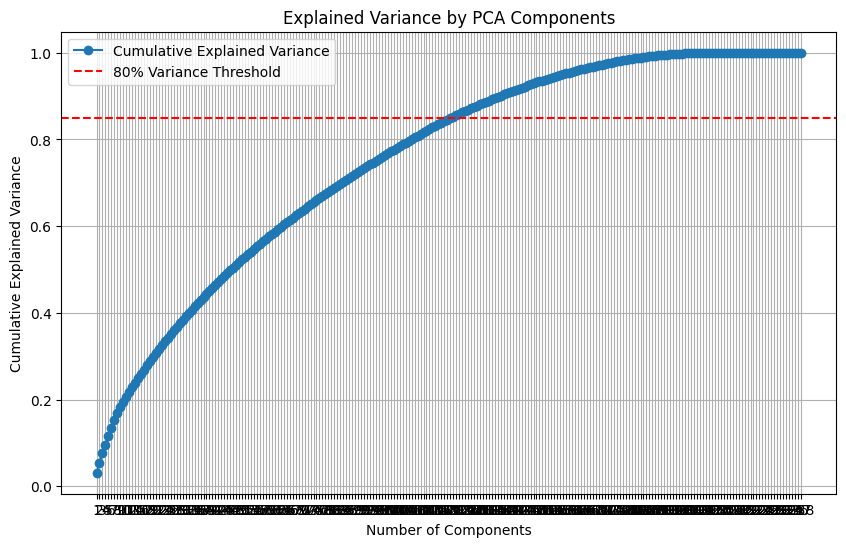

Number of components needed: 107


In [7]:
pca = PCA()  # Initialize PCA without specifying components
pca.fit(X_scaled)

# Explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plotting the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.85, color='r', linestyle='--', label='80% Variance Threshold')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.legend()
plt.grid()
plt.show()

# Calculate the number of components needed to explain at least 80% variance
components = np.argmax(cumulative_variance >= 0.80) + 1  # Add 1 to get the count of components
print(f"Number of components needed: {components}")

In [8]:
X_pca = pca.transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
first_108_pcs_df = X_pca_df.iloc[:, :108].copy()
#first_108_pcs_df

In [9]:
print(pca.components_.shape)
print(actMath_11_df.columns)

cols_drop = ['studentId', 'is_proficient', 'proficient_score']
columns_to_drop = [col for col in cols_drop if col in actMath_11_df.columns]
feature_names = actMath_11_df.drop(columns=columns_to_drop).columns

(238, 238)
Index(['studentId', 'is_proficient', 'proficient_score', 'course_ACT Review',
       'course_ACT/WK Rev.', 'course_ACTReview.5C', 'course_AG Communica',
       'course_AIDE-ELEM', 'course_AIDE-LIB', 'course_ALG I B ACCE',
       ...
       'course_YearbkII9-12', 'course_Yearbook9-12', 'course_YrbkIII9-12',
       'school_High School A', 'school_High School B', 'school_High School C',
       'school_High School D', 'iready_math', 'iready_reading',
       'bbb_literacy'],
      dtype='object', length=241)


In [10]:
components = pca.components_[:108]  
# Create a DataFrame for feature loadings
# Rows correspond to features, and columns correspond to principal components
feature_loadings_df = pd.DataFrame(
    components.T,  # Transpose to match features as rows
    columns=[f'PC{i+1}' for i in range(components.shape[0])],  # PC1, PC2, ..., PC108
    index= feature_names  # Feature names
)

# Initialize a list to store the top features across all principal components
all_top_features = []

# For each principal component, find the top features
for pc in feature_loadings_df.columns:
    # Get the absolute values of the loadings and sort them
    sorted_features = feature_loadings_df[pc].abs().sort_values(ascending=False)
    # Get the top 5 features for the current principal component (adjustable)
    top_features = sorted_features.head(5).index.tolist()
    # Add the component and its top features to the list
    for feature in top_features:
        all_top_features.append((pc, feature))

# Create a DataFrame to view all top features for each principal component
top_features_df = pd.DataFrame(all_top_features, columns=['Principal Component', 'Top Feature'])

# Display the DataFrame
print(top_features_df)

    Principal Component           Top Feature
0                   PC1    course_HEALTH 9-12
1                   PC1     course_DRIVERS ED
2                   PC1  school_High School B
3                   PC1    course_D&TSafetyEd
4                   PC1    course_Health 9-12
5                   PC2   course_Physical Sci
6                   PC2   course_English Gr10
7                   PC2    course_Algebra I B
8                   PC2    course_USHis I G10
9                   PC2    course_US His-1877
10                  PC3   course_Eng Gr10 Adv
11                  PC3   course_ChemistryAdv
12                  PC3    course_USHis I Adv
13                  PC3   course_HS US 10 ADV
14                  PC3    course_D&TSafetyEd
15                  PC4   course_Ess II:USHis
16                  PC4   course_Ess: Phy Sci
17                  PC4     course_Eng Ess 10
18                  PC4   course_Alg Esntls B
19                  PC4    course_RdIntrv7-12
20                  PC5   course_E

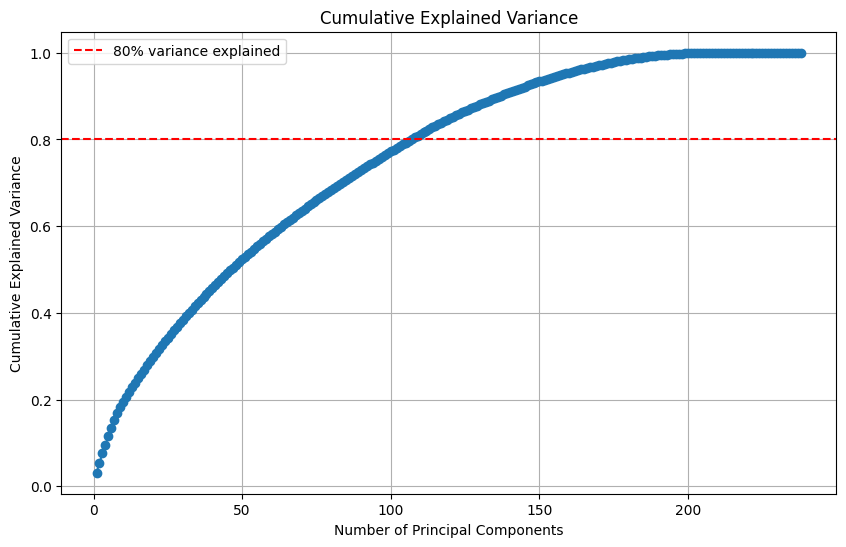

In [11]:
# Cumulative Explained Variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% variance explained')  # Adjust threshold as needed
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

Training on PCA Features

In [12]:
X = first_108_pcs_df  # PCA-transformed features
y = actMath_11_df['proficient_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)
print(X_train.shape)

(2064, 108)


In [13]:
'''
max_depth_values = [5,18,23,32]
n_estimators_value = [100,250,300,350]
param_grid = {'max_depth' : list(max_depth_values), 'n_estimators' : list(n_estimators_value)}

#Grid Search to find the best hyperparameters 
print("Running Grid Search")
rf_regressor = RandomForestRegressor()

# will have a 3-fold cross validation 
rf_grid = GridSearchCV(rf_regressor, param_grid, cv=3, scoring='neg_root_mean_squared_error')
rf_grid_search = rf_grid.fit(X_train, y_train)

print("Done")
rf_best_params = rf_grid_search.best_params_

rf_best_params'''
#{'max_depth': 18, 'n_estimators': 350}


'\nmax_depth_values = [5,18,23,32]\nn_estimators_value = [100,250,300,350]\nparam_grid = {\'max_depth\' : list(max_depth_values), \'n_estimators\' : list(n_estimators_value)}\n\n#Grid Search to find the best hyperparameters \nprint("Running Grid Search")\nrf_regressor = RandomForestRegressor()\n\n# will have a 3-fold cross validation \nrf_grid = GridSearchCV(rf_regressor, param_grid, cv=3, scoring=\'neg_root_mean_squared_error\')\nrf_grid_search = rf_grid.fit(X_train, y_train)\n\nprint("Done")\nrf_best_params = rf_grid_search.best_params_\n\nrf_best_params'

In [14]:
rf_model = RandomForestRegressor(max_depth=18, n_estimators=350)
rf_model.fit(X_train,y_train)

RandomForestRegressor(max_depth=18, n_estimators=350)

Metrics PCA

In [15]:
y_rf_pred= rf_model.predict(X_test)
rf_rmse = mean_squared_error(y_test, y_rf_pred, squared=False)
rf_r2 = r2_score(y_test, y_rf_pred)

threshold = 1
y_rf_pred_bool = y_rf_pred >= threshold
y_test_bool = y_test >= threshold

print("threshold=", threshold)
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_rf_pred_bool, y_test_bool))

print('[RF] Root Mean Squared Error: {0}'.format(rf_rmse))
print('[RF] R2: {0}'.format(rf_r2))     

threshold= 1

Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.77      0.85       392
        True       0.55      0.87      0.67       124

    accuracy                           0.80       516
   macro avg       0.75      0.82      0.76       516
weighted avg       0.85      0.80      0.81       516

[RF] Root Mean Squared Error: 0.16494811194467798
[RF] R2: 0.5022149132701228


c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [16]:
micro_f1 = f1_score(y_test_bool, y_rf_pred_bool, average='micro')

print("Micro F1 Score:", micro_f1)

Micro F1 Score: 0.7965116279069767


In [17]:
actMath_11_df[actMath_11_df.select_dtypes(include=['bool']).columns] = actMath_11_df.select_dtypes(include=['bool']).astype(int)
actMath_11_df.dtypes

studentId                 int64
is_proficient             int64
proficient_score        float64
course_ACT Review         int64
course_ACT/WK Rev.        int64
course_ACTReview.5C       int64
course_AG Communica       int64
course_AIDE-ELEM          int64
course_AIDE-LIB           int64
course_ALG I B ACCE       int64
course_ALIITRIGH/A        int64
course_ARMY LET I         int64
course_ARMY LET II        int64
course_ARMY LET III       int64
course_ARMY LET IV        int64
course_ARMYLETIVACT       int64
course_AcAdv.Baseba       int64
course_AcAdv.Basket       int64
course_AcAdv.CrossC       int64
course_AcAdv.Footb        int64
course_AcAdv.Softba       int64
course_AcAdv.Volley       int64
course_Accounting         int64
course_Adv BTA            int64
course_Advanced Agr       int64
course_Agriscience        int64
course_Alg Esntls B       int64
course_Alg II/Trig        int64
course_AlgEnrichmet       int64
course_AlgII/TrigAC       int64
course_Algebra I          int64
course_A

Training 

In [18]:
y_Math= actMath_11_df['proficient_score']
X_Math= actMath_11_df.drop(['proficient_score', 'is_proficient', 'studentId'], axis=1)
print("Number of examples: " + str(X_Math.shape[0]))
X_train_Math,X_test_Math, y_train_Math,y_test_Math = train_test_split(X_Math,y_Math, test_size=0.20,stratify=actMath_11_df['is_proficient'], random_state=123)
print(X_train_Math.shape)
print(X_test_Math.shape)


Number of examples: 2580
(2064, 238)
(516, 238)


In [19]:
'''
max_depth_values_math = [18,23,32]
n_estimators_value_math = [100,250,300,350]
param_grid = {'max_depth' : list(max_depth_values_math), 'n_estimators' : list(n_estimators_value_math)}

print("Running Grid Search")
rf_regressorMath = RandomForestRegressor()

# will have a 3-fold cross validation 
rf_gridMath = GridSearchCV(rf_regressorMath, param_grid, cv=3, scoring='neg_root_mean_squared_error')
rf_grid_searchMath = rf_gridMath.fit(X_train_Math, y_train_Math)

print("Done")
rf_best_paramsMath = rf_grid_searchMath.best_params_

rf_best_paramsMath

#{'max_depth': 32, 'n_estimators': 250}
'''


'\nmax_depth_values_math = [18,23,32]\nn_estimators_value_math = [100,250,300,350]\nparam_grid = {\'max_depth\' : list(max_depth_values_math), \'n_estimators\' : list(n_estimators_value_math)}\n\nprint("Running Grid Search")\nrf_regressorMath = RandomForestRegressor()\n\n# will have a 3-fold cross validation \nrf_gridMath = GridSearchCV(rf_regressorMath, param_grid, cv=3, scoring=\'neg_root_mean_squared_error\')\nrf_grid_searchMath = rf_gridMath.fit(X_train_Math, y_train_Math)\n\nprint("Done")\nrf_best_paramsMath = rf_grid_searchMath.best_params_\n\nrf_best_paramsMath\n\n#{\'max_depth\': 32, \'n_estimators\': 250}\n'

In [20]:
print('Begin Random Forest ')
rf_model_Math = RandomForestRegressor(max_depth=32, n_estimators=250)
rf_model_Math.fit(X_train_Math,y_train_Math)
print('End')

Begin Random Forest 
End


Metrics all columns

In [21]:
y_rf_pred_Math = rf_model_Math.predict(X_test_Math)
rf_rmse_Math = mean_squared_error(y_test_Math, y_rf_pred_Math, squared=False)
rf_r2_Math = r2_score(y_test_Math, y_rf_pred_Math)

#trying to get f1 and accuracy score 
threshold = 1
y_rf_pred_Math_bool = y_rf_pred_Math >= threshold
y_test_Math_bool = y_test_Math >= threshold

print("threshold=", threshold)
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test_Math_bool, y_rf_pred_Math_bool))
print('[RF] Root Mean Squared Error: {0}'.format(rf_rmse_Math))
print('[RF] R2: {0}'.format(rf_r2_Math))    

#extracting from classification report for bar graph
report = classification_report(y_test_Math_bool, y_rf_pred_Math_bool,output_dict=True)

# Extract accuracy from the report dictionary
accuracy = report['accuracy']

# Extract other metrics you want to plot, like precision and recall for the "True" class
precision_true = report['True']['precision']
recall_true = report['True']['recall']


threshold= 1

Classification Report:
              precision    recall  f1-score   support

       False       0.78      0.96      0.86       329
        True       0.89      0.53      0.66       187

    accuracy                           0.81       516
   macro avg       0.84      0.75      0.76       516
weighted avg       0.82      0.81      0.79       516

[RF] Root Mean Squared Error: 0.16894143627234093
[RF] R2: 0.5007634560684495


c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [22]:
#looking at the micro score
micro_f1 = f1_score(y_test_Math_bool, y_rf_pred_Math_bool, average='micro')

print("Micro F1 Score:", micro_f1)

Micro F1 Score: 0.8062015503875969


bar plot

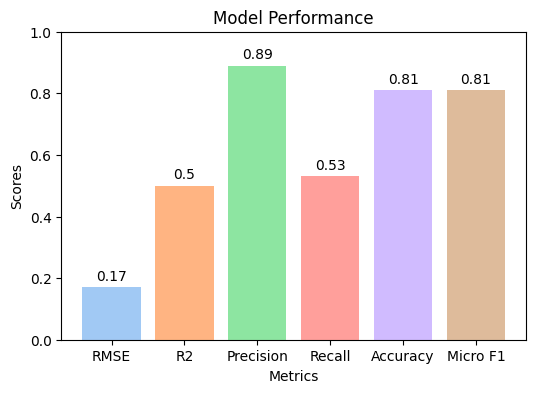

In [23]:
metrics = ['RMSE', 'R2', 'Precision', 'Recall', 'Accuracy', 'Micro F1']
values = [rf_rmse_Math,rf_r2_Math,precision_true,recall_true,accuracy,micro_f1]

rounded_values = [round(value, 2) for value in values]

# Get a pastel color palette
pastel_colors = sns.color_palette("pastel", len(metrics))

# Plot the bar chart with pastel colors
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(metrics, rounded_values, color=pastel_colors)

ax.bar_label(bars, padding=3, fontsize=10)  # padding adds space between bar and label
ax.set_ylim(0, 1)  # This will ensure the y-axis goes from 0 to 1

# Add labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Performance')

# Display the plot
plt.show()

Confusion Matrix:
[[317  12]
 [ 88  99]]


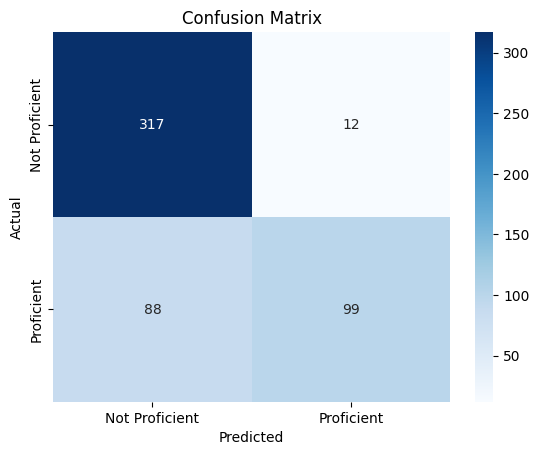

In [24]:
cm = confusion_matrix(y_test_Math_bool, y_rf_pred_Math_bool)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optionally, plot the confusion matrix using seaborn heatmap for better visualization
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Proficient", "Proficient"], yticklabels=["Not Proficient", "Proficient"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Feature Importance

In [25]:
importances = rf_model_Math.feature_importances_
feature_names = X_train_Math.columns

# Combine names and importances, and sort
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df= importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted DataFrame
print(importance_df)

                  Feature    Importance
58    course_ChemistryAdv  2.600100e-01
84      course_Enviro Sci  3.846860e-02
156    course_Phy Sci Adv  2.366149e-02
29     course_Algebra I B  2.288101e-02
40    course_BandConcer.5  1.613305e-02
177      course_Spanish 1  1.586949e-02
123   course_Intermed Agr  1.371441e-02
128   course_Journalism 1  1.345838e-02
131   course_LIFE PE 9-12  1.307086e-02
82    course_English Gr11  1.258058e-02
208         course_VarFBI  1.143800e-02
229   course_Yearbook9-12  1.086639e-02
76    course_Eng Gr10 Adv  1.081519e-02
9      course_ARMY LET II  1.047307e-02
218     course_VisArtI.5C  1.038668e-02
140   course_Multimed Des  1.027936e-02
209        course_VarFBII  1.013954e-02
163    course_Psyc AP Acc  9.848518e-03
152       course_Painting  9.504424e-03
171      course_SPANISH I  9.214161e-03
222     course_Vocal II 1  9.138123e-03
105   course_Geometry Adv  9.036149e-03
186      course_Theatre I  8.560456e-03
146   course_MusicalDrama  8.141194e-03


In [27]:
importance_df.head(25)

,Feature,Importance
58,course_ChemistryAdv,0.260010
84,course_Enviro Sci,0.038469
156,course_Phy Sci Adv,0.023661
29,course_Algebra I B,0.022881
40,course_BandConcer.5,0.016133
177,course_Spanish 1,0.015869
123,course_Intermed Agr,0.013714
128,course_Journalism 1,0.013458
131,course_LIFE PE 9-12,0.013071
82,course_English Gr11,0.012581


In [28]:
specific_feature_importance = importance_df[importance_df['course_Algebra I Adv'] == feature_names]


KeyError: 'course_Algebra I Adv'